# Introduction

The I am interested in order to understand the current situation, just how serious it is, how we got here, and where it may lead us. My ultimate aim is to predict dam levels given available data, in order to forecast how long it will take for the dam levels to reach sustainable levels - where we can relax somewhat that we won't run out of water in the following summer. The term 'new normal' has been thrown out a lot. And it's possible that we may never be able to fully relax about our water security. My question is simply when we can expect dams to be at a level where we don't have to worry about running out imminently.

In this post, I perform some exploratory analysis on the dam levels data, available publicy at the City of Cape Town's Open Data Portal here. The original and cleaned datasets are also available in repo housing this script. I downloaded the data on 12 Dec 2017 but it seems to be updated frequently.

There are 4 sections to this notebook. Each addresses a different problem:
1. Provide my own estimate for when the city will run out of water.
2. Figure out what water level is needed going in to next summer so that we don't run out of water.
3. Estimate how long it would take for dams to be replenished during the next rainy season to reach the requisite level.
4. Determine what a 2-year 'sustainable' dam capacity is. In other words, how high do the dams need to be going into summer *next year* to obviate our running out of water in 2019 if that year sees another bad rainy season?

In [3]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from textwrap import wrap

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Read and prep dam level data
dam_levels = pd.read_csv('data/processed/Dam-levels-clean-20120101-20171206.csv', encoding = 'latin1')
dam_levels['date'] = pd.to_datetime(dam_levels['date'])
# Read and prep aggregated dam level data
agg_storage_ml = pd.read_csv('data/processed/agg-storage-ml.csv')
agg_storage_ml['date'] = pd.to_datetime(agg_storage_ml['date']).dt.date
agg_storage_ml.index = agg_storage_ml['date']
agg_storage_ml.index.name = 'date'

TOTAL_DAM_CAPACITY = 902598  # Total dam capacity 

# The Crisis

The graph below shows the dam levels for each day since 2012, with the red line marking the *usable* storage limit (10% of each dam's capacity is 'unavailable' because it's extraction is not feasible). From this, we can see just how dangerously close we are coming to running out of water. The winter rains have helped to prop up the dam levels somewhat, but it's easy to see that the drop between October and April 2016 is far greater than the available storage at the height of the dam levels in October 2017 - the same drop this year and we run out of water.

This graph also suggests how we got here. The winters between 2012 and 2015 saw the dam levels reaching capacity. As late as 2014, the level didn't drop below 75% in the summer. This shows how unexpected and novel the current situation is. It's not as if the levels have been slowly decreasing each year for many years. It's only from 2015 that we see the dry winters and long summers starting to take their toll. Moreover, the current year's rainy season has been dreadful, compared even to the last 2 years. 

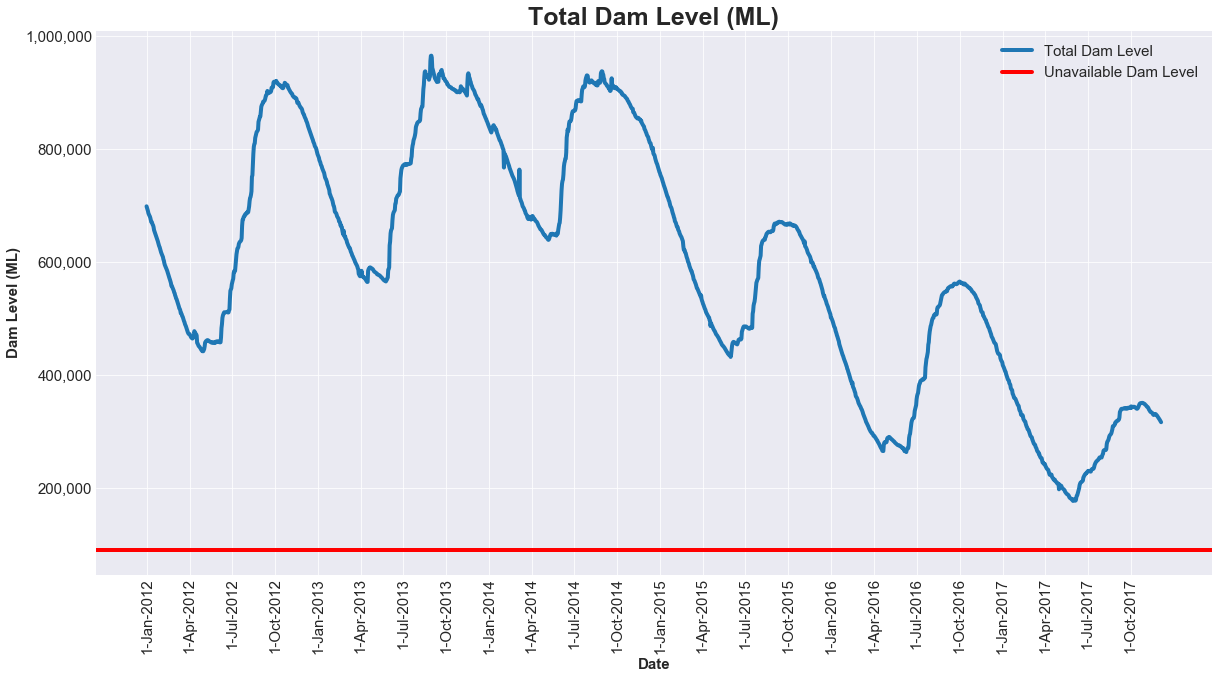

In [4]:
sns.set_style("darkgrid")  # Sets style for pyplot graphs to match seaborn

fig, ax = plt.subplots(figsize=[20,10]) # [w, h]
plt.plot(range(len(agg_storage_ml)), agg_storage_ml['storage_ml'], label = 'Total Dam Level', linewidth = 4)
ax.axhline(y = 0.1 * TOTAL_DAM_CAPACITY,  label = 'Unavailable Dam Level',  c = 'red', linewidth = 4)

# In the plot that follows, we'll want to be smart about how we label the x-axis. Too many labels will make it 
# unreadable but having too few will make it more difficult to see what date period we're looking at. 
# Generally we'll want to plot the 1st date of every month at a particular interval. We need to calculate an 
# associated index, which will tell the plotting library where to place the labels - that's what the `dayofyear` 
# and `cumsum_dayofyear` columns are doing in the dataframe below.
first_day_of_month = dam_levels.loc[(dam_levels['dayofmonth'] == 1), ['date', 'month', 'daymonthyear']].drop_duplicates()
first_day_of_month['lag_date'] = first_day_of_month['date'].shift(periods = 1)
first_day_of_month['cumsum_dayofyear'] = (first_day_of_month['date'] - first_day_of_month['lag_date']).dt.days.cumsum().fillna(0) + 1
first_day_of_quarter = first_day_of_month[first_day_of_month['month'].isin([1, 4, 7, 10])]

plt.title('Total Dam Level (ML)', fontsize = 25, fontweight = 'bold');
plt.xticks(first_day_of_quarter['cumsum_dayofyear'], first_day_of_quarter['daymonthyear'], rotation = 90, fontsize = 15);
plt.xlabel('Date', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 15)
plt.ylabel('Dam Level (ML)', fontsize = 15, fontweight = 'bold')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# plt.ylim(ymin = 0)
plt.legend(fontsize = 15)
plt.show();

The crisis also isn't only a problem of not enough rain in the rainy season but also too much *net* water consumption in the dry seasons - the drawdown of the dams less any additional water through summer rains and the like. In particular, the 2015 summer was particularly bad, depleting dam storage by more than 50% more than in the previous year. The table below gives us some more insights.

In [5]:
# Find values at start of 'wet season' - defined here as when dam levels are at their minimum
min_storage = agg_storage_ml.loc[agg_storage_ml.groupby('year')['storage_ml'].idxmin(), ['year', 'storage_ml']]
min_storage = min_storage.reset_index()[['year', 'date', 'storage_ml']]
min_storage = min_storage.rename(columns = {'date': 'wet_season_start_date',
                                           'storage_ml': 'start_storage_ml'})

# Find values at end of 'wet season' - defined here as when dam levels are at their maximum (after wet season has begun)
max_storage = pd.merge(agg_storage_ml, min_storage, on = ['year'])
max_storage.index = max_storage['date']
max_storage = max_storage.loc[max_storage['date'] > max_storage['wet_season_start_date']]  # Must make sure we're looking for max level AFTER start of wet season
max_storage = max_storage.loc[max_storage.groupby('year')['storage_ml'].idxmax(), ['year', 'storage_ml']]
max_storage = max_storage.reset_index()[['year', 'date', 'storage_ml']]
max_storage = max_storage.rename(columns = {'date': 'wet_season_end_date',
                                           'storage_ml': 'end_storage_ml'})

# Combine data for start and end of wet season
season_summary = pd.merge(min_storage, max_storage, on = ['year'], copy = False)
season_summary = season_summary.rename(columns = {'date': 'wet_season_start_date'})

# Length of wet and dry seasons, respectively (days)
season_summary['wet_season_length'] = (season_summary['wet_season_end_date'] - season_summary['wet_season_start_date']).dt.days  
season_summary['dry_season_length'] = (season_summary['wet_season_start_date'] - season_summary['wet_season_end_date'].shift(periods = 1)).dt.days

# Find change in storage over dry and wet seasons respectively
season_summary['wet_season_change'] = season_summary['end_storage_ml'] - season_summary['start_storage_ml'] 
season_summary['dry_season_change'] = season_summary['start_storage_ml'] - season_summary['end_storage_ml'].shift(periods = 1)

# Reorder columns
season_summary = season_summary[['year', 'wet_season_start_date', 'wet_season_end_date', 'start_storage_ml', 
                        'end_storage_ml', 'wet_season_change', 'dry_season_change', 
                         'wet_season_length', 'dry_season_length']]

# Combine data on start and end of wet season back to daily storage during wet season
wet_season_storage = pd.merge(agg_storage_ml, season_summary, on = ['year'])
wet_season_storage = wet_season_storage[(wet_season_storage['date'] >= wet_season_storage['wet_season_start_date']) &
                       (wet_season_storage['date'] <= wet_season_storage['wet_season_end_date'])]



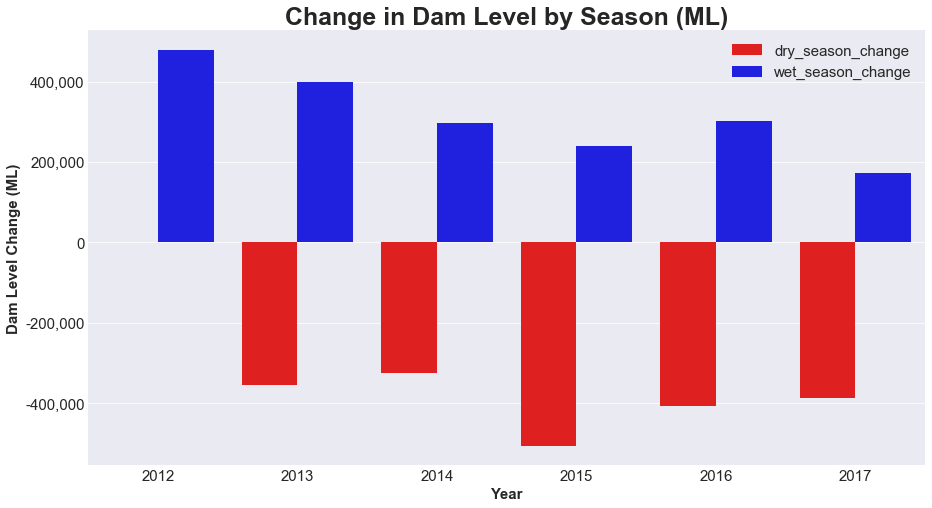

In [6]:
# Melt `wet_season` for seaborn boxplot
season_summary_melt = pd.melt(season_summary[['year', 'dry_season_change', 'wet_season_change']], 
                          id_vars = 'year', var_name = 'season', value_name = 'storage_change')

fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x = 'year', y = 'storage_change', hue = 'season', data = season_summary_melt, palette = ['red', 'blue'])
plt.title('Change in Dam Level by Season (ML)', fontsize = 25, fontweight = 'bold')
plt.xlabel('Year', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 15)
plt.ylabel('Dam Level Change (ML)', fontsize = 15, fontweight = 'bold')
plt.xticks(fontsize = 15)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.legend(fontsize = 15)
plt.show();

We can see from the below table that the wet seasons from 2015 to 2017 started in June, much later than 2012 and 2013, where it started in April and May. The season was also muc shorter on average during the years following 2013, than the 2 years before.

In [7]:
season_summary.style.format({
    'start_storage_ml': '{:,.0f}'.format,
    'end_storage_ml': '{:,.0f}'.format,
    'wet_season_change': '{:,.0f}'.format,
    'dry_season_change': '{:,.0f}'.format,
})

,year,wet_season_start_date,wet_season_end_date,start_storage_ml,end_storage_ml,wet_season_change,dry_season_change,wet_season_length,dry_season_length
0,2012,2012-05-01,2012-10-04,"441,568","919,933","478,366",nan,156,nan
1,2013,2013-04-16,2013-08-31,"564,195","964,590","400,395","-355,738",137,194
2,2014,2014-05-08,2014-08-30,"638,676","936,987","298,311","-325,914",114,250
3,2015,2015-06-01,2015-09-13,"431,543","670,787","239,244","-505,444",104,275
4,2016,2016-06-10,2016-10-02,"263,272","564,967","301,696","-407,515",114,271
5,2017,2017-06-01,2017-10-28,"176,777","350,279","173,501","-388,190",149,242


I only have dam levels since 2012 so I can't say whether the 2012-2013 wet seasons are representative of previous years. It may well be that they are an anomaly and that previous years were very different. However, it provides context to the recent dam levels and suggests what has caused our current predicament. Analysis weather conditions over this, and prior, periods could provide a glimpse into how characteristic 2012-2013 were but I'll leave that for another time.

# 1. When will we run out of water?

There have been estimates for when the city will run out of water - notably from the [CSAG](http://www.csag.uct.ac.za/2017/10/24/waiting-for-the-rain/) and [this](http://www.howmanydaysofwaterdoescapetownhaveleft.co.za/) website. While the latter doesn't disclose how they arrived at their number, the former, written by [Piotr Wolski](http://www.csag.uct.ac.za/author/pwolski/) does. My approach will follow his logic. My contribution here will be in providing an updated figure, based on current dam levels and usage stats.

Let's assume that there are no meaningful inflows of water into the dams during the summer period. Then we can work out the number of days of water we have left with this simple formula:
$$d = {s \over c}$$

where:
+ d = number of days remaining
+ s = current volume of water storaged in the dams
+ c = average daily water consumption

The City of Cape Town (CoCT) published a ("water dashboard"](https://resource.capetown.gov.za/documentcentre/Documents/City%20research%20reports%20and%20review/damlevels.pdf), which states that the total volume of dammed water is 282,417Ml. However, the last 10% of the water is unusable, since it become impossible to extract. The total capacity is 902,598Ml, which means that we need to subtract 90,259.8Ml, which leaves us 192,157Ml remaining. 

The same source shows daily consumption by the City at 561Ml (Ml = "megalitres") per day. So we almost have everything we need to plug in to the above formula and solve for the days. However, we only have the *City's* consumption. According to the Water & Sanitation Department, CoCT's share of total water consumption is only 40%. This is illustrated in the chart below, which can be found [here](https://www.groundup.org.za/media/uploads/documents/BusinessBriefingOnWaterCrisis9MayPeterFlowerPresentationHandout.pdf):

<img src= resources/waterusewcwss.png style="width: 350px;"/>

So if we want to get the *total* water consumption, we need to scale up the the consumption by a factor of 100/40 = 2.5. This means that total consumtpion is 1402.5Ml per day. This means that we have 192,157/1,402.5 = 137 days left. This puts 'day zero' at 19 May 2018.

In [8]:
(datetime.date.today() + datetime.timedelta(days = 137)).strftime('%Y-%m-%d')

'2018-05-26'

The table below shows the same for different consumption levels:

# 2. How much water do we need going in to summer?

How much water do we need in the dams at the beginning of summer to last us through the season, until the winter rains come? This depends on how much water we use. I will attempt to answer this question given historical, current, and target water usage levels.

If we again assume that there will be no meaningful inflows of water into the dams during the dry season, we can can just rearrange the equation above and solve for *s* - the total storage needed is the sum of all the water consumed each day over all the days in the dry season: 
$$s = d \times c$$

Eyeballing dam storage graph above, we can see that dam levels tend to drop off from between the beginning of October to the latter half of June. Let's use the average number of days in the dry seasons in the past 4 years to be conservative. That gives us 260 days.

In [9]:
season_summary.loc[season_summary['year'] >= 2014, 'dry_season_length'].mean()

259.5

The consumption level is a parameter that we'll need to assume. If we assume current consumption levels, plugging in to our equation above, we get $s = 260 * 1,402.5 = 402,517.5$. We can do the same for different consumption levels. The results are displayed in the table below:

In [10]:
storage_needed = pd.DataFrame()
storage_needed['CoCT Avg Daily Consumption'] = [500, 561, 600]
storage_needed['Total Avg Daily Consumption'] = 2.5 * storage_needed['CoCT Avg Daily Consumption']
storage_needed['Storage Needed'] = 287 * storage_needed['Total Avg Daily Consumption']
storage_needed.style.format('{:,.0f}')

,CoCT Avg Daily Consumption,Total Avg Daily Consumption,Storage Needed
0,500,"1,250","358,750"
1,561,"1,402","402,518"
2,600,"1,500","430,500"


# 3. How long until dam levels are high enough for next summer?

The wet season brings rains, which will cause dam levels to increase. Generally, there are enough rains each year that we don't need to worry about running out by the end of the proceeding dry season. However, that is not a given. If we assume that we have no water left by the end of the current dry season, can the dams be replenished in one season? This assumes, of course, that no additional water is added to the system. We know that the City has plans in place to supplement the water naturally supplied by the rains. However, how much do they need to supply?

I will assume that the daily average consumption remains sy 561ML so that we need 402,518Ml. If we have usable water left by the end of summer this year, how long will it take us to get back to that level? We can fit a line to the dam levels relative to the start of the rainy season each year and see how long it takes that line to reach the needed level. Let's do this separately for 2012-2013 ('good season'), 2014-2016 ('bad season'), and 2017 (which is in a dismal league of it's own - 'worse season')

To be conservative, I'm going to assume that the beginning of the wet season is when the dams are at their minimum levels for the year and the end of the wet season is the day the maximum dam storage is reached after the rainy season has begun.

In [24]:
aligned_wet_seasons = {}
flat_wet_seasons = pd.DataFrame()
for y in list(range(2012,2018)):
    season = pd.DataFrame()
    season['date'] = wet_season_storage.loc[wet_season_storage['year'] == y, 'date']
    season['season_day'] = list(range(len(season['date'])))
    season['storage_ml'] = (wet_season_storage.loc[wet_season_storage['year'] == y, 'storage_ml'] - wet_season_storage.loc[wet_season_storage['year'] == y, 'start_storage_ml']).tolist()
    aligned_wet_seasons[y] = season
    flat_wet_seasons = pd.concat([flat_wet_seasons, season], axis = 0)
    
f = np.polyfit(flat_wet_seasons['season_day'], flat_wet_seasons['storage_ml'], deg = 3)
all_fit = np.poly1d(f)

flat_wet_seasons_good = flat_wet_seasons[pd.to_datetime(flat_wet_seasons['date']).dt.year.isin([2012, 2013])]
f = np.polyfit(flat_wet_seasons_good['season_day'], flat_wet_seasons_good['storage_ml'], deg = 3)
good_season_fit = np.poly1d(f)

flat_wet_seasons_bad = flat_wet_seasons[pd.to_datetime(flat_wet_seasons['date']).dt.year.isin([2014, 2015, 2016])]
f = np.polyfit(flat_wet_seasons_bad['season_day'], flat_wet_seasons_bad['storage_ml'], deg = 3)
bad_season_fit = np.poly1d(f)

flat_wet_seasons_worst = flat_wet_seasons[pd.to_datetime(flat_wet_seasons['date']).dt.year.isin([2017])]
f = np.polyfit(flat_wet_seasons_worst['season_day'], flat_wet_seasons_worst['storage_ml'], deg = 3)
worst_season_fit = np.poly1d(f)

good_season_fit
bad_season_fit
worst_season_fit

poly1d([ -2.30564632e-01,   6.52467389e+01,  -1.58971684e+03,
         1.87433804e+04])

poly1d([ -3.38683034e-01,   3.93171010e+01,   2.32138843e+03,
        -4.35959214e+03])

poly1d([ -8.71122912e-02,   1.54696941e+01,   7.05452363e+02,
         8.38487957e+03])

In [28]:
225000/900000

0.25

The plot below shows fitted lines for:
+ Good rainy seasons (2012-2013) - blue
+ Bad rainy seasons (2014-2016) - orange
+ Worst rainy seasons (2017) - red

The dotted horizontal line is the minimum level that needs to be reached going in to summer so that we don't run out (assuming current consumption levels). This will only be reached in the good-case scenario, in which case we can expect it to be achieved in about 130 days. In the other scenarios, the requisite levels won't be reached in one season. In the bad scenario, levels reach about 280,000ML, which means that the City will need to add at least 120,000ML into the system. In the worst-case scenario, we only reach a dam level of 175,000ML by the end of the rainy season, which means that the City will have to find an additional 225,000ML. This is a staggering amount - about 25% of the total storage in the entire system! 

We should be reminded here that this assumes that we run out of water at the end of the current (2017-2018) dry season. This might not happen due to additional supply by the City, water conservation, or restrictions. Given what's at stake, these may be necessary. 

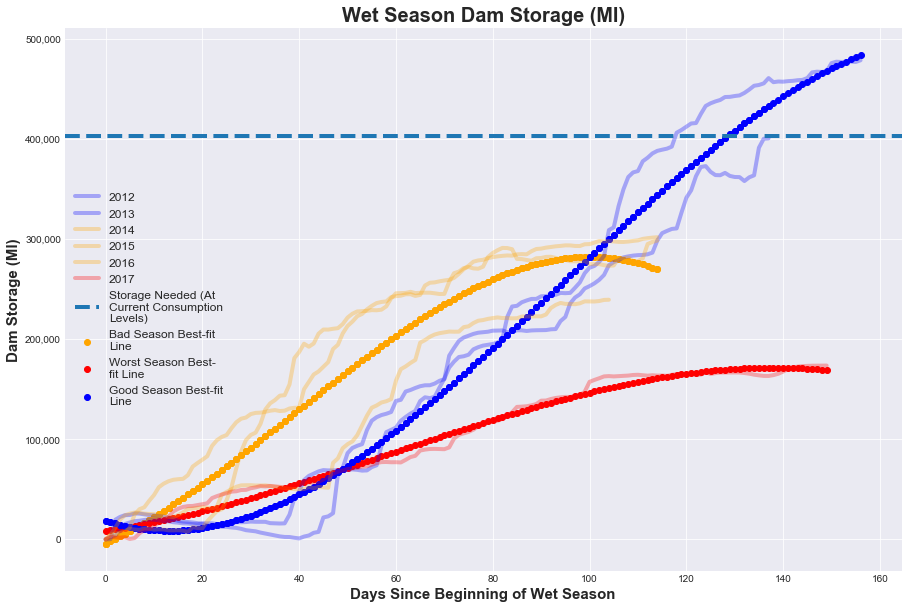

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
colours = [
    'blue',
    'blue',
    'orange',
    'orange',
    'orange',
    'red',
]

y = list(range(2012,2018))
# y = [2012,2013,2015,2016]
for i, y in enumerate(y):
    plt.plot(aligned_wet_seasons[y]['season_day'], aligned_wet_seasons[y]['storage_ml'], label = y, 
             c = colours[i], linewidth = 4, alpha = 0.3)
ax.axhline(402518, linewidth = 4, label = 'Storage Needed (At Current Consumption Levels)', linestyle = '--')
# plt.scatter(flat_wet_seasons['season_day'], all_fit(flat_wet_seasons['season_day']), 
#             c = 'green', label = 'Total Best-fit Line')
plt.scatter(flat_wet_seasons_bad['season_day'], bad_season_fit(flat_wet_seasons_bad['season_day']), 
            c = 'orange', label = 'Bad Season Best-fit Line')
plt.scatter(flat_wet_seasons_worst['season_day'], worst_season_fit(flat_wet_seasons_worst['season_day']), 
            c = 'red', label = 'Worst Season Best-fit Line')
plt.scatter(flat_wet_seasons_good['season_day'], good_season_fit(flat_wet_seasons_good['season_day']), 
            c = 'blue', label = 'Good Season Best-fit Line')

plt.title('Wet Season Dam Storage (Ml)', fontsize = 20, fontweight = 'bold')
plt.xlabel('Days Since Beginning of Wet Season', fontsize = 15, fontweight = 'bold', )
plt.ylabel('Dam Storage (Ml)', fontsize = 15, fontweight = 'bold')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

handles, labels = ax.get_legend_handles_labels()
labels = [ '\n'.join(wrap(lab, 20)) for lab in labels]
ax.legend(labels, fontsize = 12)

plt.show();

# 3. What dam storage is sustainable at the beginning of summer?
By *sustainable* dam storage, I mean that we have enough water to last us, not only through the impending summer season, but, in combination with water production in winter, the *following* season. By *water production*, I mean addional water storage added to the dams - whether by precipitation or other means, such as desalination. Why could this be different from the question that I answered above, regarding how much water we need going in to summer? If the net water production (water production less water usage) during the winter season does not at least equal the amount we use during summer, then we need some water left in the dam after summer is over to make the difference. We have seen from the above analysis that it is possible to go from zero water to having enough (based on current consumption, which takes into account strict rationing) to last the following winter. I don't call this sustainable because we don't know what is going to happen in the future and to be so dependent on one good season is probably not a good strategy. A different way of formulating this question is, how much water do we need such that *if we have a bad winter, we don't run out of water*. This will depend on water usage throughout winter, as well as how much water finds it's way into the system throughout the period. 

If we assume that we need at 402,518Ml in the dam at the beginning of the 2019 dry season, we can think through good and bad weather scenarios for next year's wet season to figure out how much we would need at the end of the 2018 wet season. We can see from the last section that the most water we can hope for in a bad season is 301696ML and 478366Ml in a good one. If there is a good season next year, then, we won't run out of water even if we ran out of water this year and resorted to having to buy in water. However, in the bad scenario ,we would need about 100822Ml, which means that we would need 503340 left at the end of this year's rainy season. Even in a good year, we wouldn't get that much rain in one season (we would be about 25000Ml short). So to have a sustainable amount of water for a 2-year period, we would still need to likely top-up or ratio water.

In [26]:
flat_wet_seasons_bad.max()
flat_wet_seasons_good.max()

date          2016-10-02 00:00:00
season_day                    114
storage_ml                 301696
dtype: object

date          2013-08-31 00:00:00
season_day                    156
storage_ml                 478366
dtype: object

# Conclusion